In [1]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F


from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    
# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 1

# Architecture
NUM_FEATURES = 28*28
NUM_CLASSES = 4

# Other
DEVICE = "cuda:0"#"cpu"#"cuda:1"
GRAYSCALE = True

CUDA available: True
Number of GPUs: 1
Current device: 0
Device name: NVIDIA GeForce GTX 1660 Ti


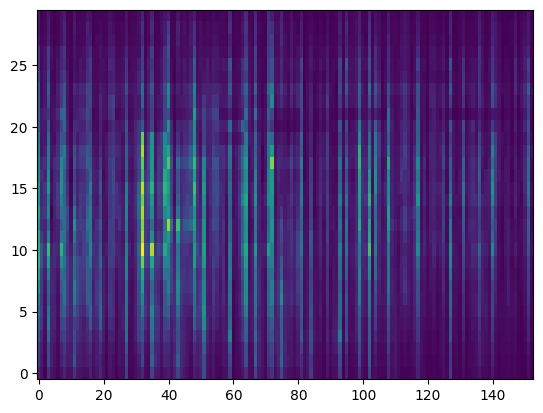

In [13]:
# Note transforms.ToTensor() scales input images
# to 0-1 range
fft_data_all = np.load('data/andy_practice/fft_data.npy')
fft_data_labels = np.load('data/andy_practice/labels.npy')

# only keeps the relevant part of the FFT, note this may change based on the 
lower_freq_index = 115
upper_freq_index = 145
fft_data_clipped = np.transpose(fft_data_all[:,:,lower_freq_index:upper_freq_index])

#load a single image as a sense check [x,y,n]
fft_data_single = fft_data_clipped[:,:,0]
plt.imshow(np.abs(fft_data_single), aspect='auto', cmap='viridis', origin='lower')

Image batch dimensions: torch.Size([32, 1, 30, 153])
Image label dimensions: torch.Size([32])


Text(0.5, 1.0, 'Label: 2')

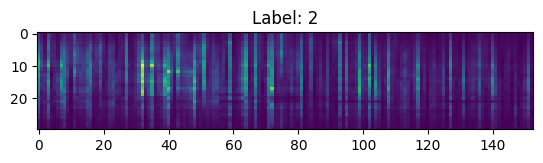

In [38]:
from torch.utils.data import Dataset, DataLoader, random_split

class SpectrogramDataset(Dataset):
    def __init__(self, data_path='data/andy_practice/fft_data.npy', labels_path='data/andy_practice/labels.npy', transform=None):
        self.data = np.load(data_path)  
        self.labels = np.load(labels_path)  # shape: [N]
        self.transform = transform
        self.lower_freq_index = 115
        self.upper_freq_index = 145
        self.data = fft_data_all[:,:,self.lower_freq_index:self.upper_freq_index] # shape: [N, 153, 35]
        self.data = np.transpose(self.data, (0,2,1)) # shape: [N, 35, 153]

        # Create mapping from label string to int
        unique_labels = sorted(set(self.labels))
        self.label2idx = {label: idx for idx, label in enumerate(unique_labels)}
        # Reverse the label2idx mapping to get the label from index
        self.idx2label = {idx: label for label, idx in self.label2idx.items()}  

        # Encode all labels
        self.encoded_labels = np.array([self.label2idx[label] for label in self.labels])

    def __len__(self):
        return len(self.encoded_labels)

    def __getitem__(self, idx):
        image = self.data[idx]  # shape: [40, 153]
        label = self.encoded_labels[idx]
        
        # Convert to PIL image-like shape and apply transform
        image = image.astype(np.float32)
        image = np.expand_dims(image, axis=0)  # shape: [1, 40, 153]
        #image = np.repeat(image, 3, axis=0)    # shape: [3, 40, 153] for ResNet-18

        if self.transform:
            image = self.transform(torch.from_numpy(image))
        else:
            image = torch.from_numpy(image)

        return image, int(label)
    
transform = transforms.Compose([
    #transforms.Resize((224, 224)),  # Optional: ResNet expects 224x224
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1, 1]
])

# Load full dataset
full_dataset = SpectrogramDataset(
    data_path='data/andy_practice/fft_data.npy',
    labels_path='data/andy_practice/labels.npy',
    transform=transform
)

# Set the split ratio
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split into train/test
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Select the first image in the batch
img = images[0]  # shape: [C, H, W]
img = img.squeeze().numpy()
label = labels[0]

plt.imshow(img, cmap='viridis' if len(img.shape) == 2 else None)
plt.title(f"Label: {label}")

In [23]:
device = torch.device(DEVICE)
torch.manual_seed(0)

for epoch in range(2):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)
        break

Epoch: 1 | Batch index: 0 | Batch size: 32
Epoch: 2 | Batch index: 0 | Batch size: 32


# ResNet-18 Model

In [28]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(2560 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        # because MNIST is already 1x1 here:
        # disable avg pooling
        #x = self.avgpool(x)
        
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        probas = F.softmax(logits, dim=1)
        return logits, probas



def resnet18(num_classes):
    """Constructs a ResNet-18 model."""
    model = ResNet(block=BasicBlock, 
                   layers=[2, 2, 2, 2],
                   num_classes=NUM_CLASSES,
                   grayscale=GRAYSCALE)
    return model


In [29]:
torch.manual_seed(RANDOM_SEED)

model = resnet18(NUM_CLASSES)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

# Training

In [30]:
def compute_accuracy(model, data_loader, device):
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(device)
        targets = targets.to(device)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100
    

start_time = time.time()
for epoch in range(NUM_EPOCHS):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, NUM_EPOCHS, batch_idx, 
                     len(train_loader), cost))

        

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%%' % (
              epoch+1, NUM_EPOCHS, 
              compute_accuracy(model, train_loader, device=DEVICE)))
        
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/001 | Batch 0000/0004 | Cost: 2.2857
Epoch: 001/001 | Train: 76.923%
Time elapsed: 0.01 min
Total Training Time: 0.01 min


In [31]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

Test accuracy: 76.92%


Text(0.5, 1.0, 'soil_dry')

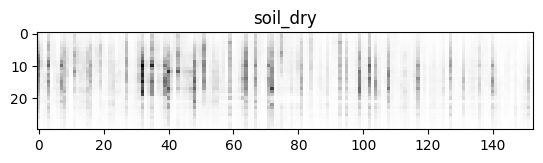

In [44]:
for batch_idx, (features, targets) in enumerate(test_loader):

    features = features
    targets = targets
    break
    
    
nhwc_img = np.transpose(features[0], axes=(1, 2, 0))
nhw_img = np.squeeze(nhwc_img.numpy(), axis=2)
plt.imshow(nhw_img, cmap='Greys')
label = full_dataset.idx2label[targets[0].item()]
plt.title(label)

In [45]:
model.eval()
logits, probas = model(features.to(device)[0, None])
print(probas)

tensor([[0.1814, 0.1679, 0.5724, 0.0783]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [46]:
# For a given prediction index (assuming it comes from your model's output)
print(f"Labels in dataset: {full_dataset.idx2label}")
predicted_class = torch.argmax(probas, dim=1).item()
predicted_label = full_dataset.idx2label[predicted_class]
print(f'Predicted label: {predicted_label}')

Labels in dataset: {0: np.str_(' desk'), 1: np.str_('desk'), 2: np.str_('soil_dry')}
Predicted label: soil_dry
